# 주가 예측 모델 구축

## 1. 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras import regularizers

In [2]:
esgu = pd.read_csv('../데이터셋/ESGU.csv', encoding='cp949')
erth = pd.read_csv('../데이터셋/^GSPC.csv', encoding='cp949')
vde = pd.read_csv('../데이터셋/VDE.csv', encoding='cp949')
nulg = pd.read_csv('../데이터셋/NULG.csv', encoding='cp949')
tan = pd.read_csv('../데이터셋/TAN.csv', encoding='cp949')
susa = pd.read_csv('../데이터셋/SUSA.csv', encoding='cp949')

# 전통 에너지 관련 주가 데이터
xom = pd.read_csv('../데이터셋/XOM.csv')
eog = pd.read_csv('../데이터셋/EOG.csv')
mpc = pd.read_csv('../데이터셋/MPC.csv')
kmi = pd.read_csv('../데이터셋/KMI.csv')
btu = pd.read_csv('../데이터셋/BTU.csv')

# 친환경 에너지 관련 주가 데이터
nee = pd.read_csv('../데이터셋/NEE.csv')
fslr = pd.read_csv('../데이터셋/FSLR.csv')
enph = pd.read_csv('../데이터셋/ENPH.csv')
run = pd.read_csv('../데이터셋/RUN.csv')

## 2. 뉴스 감성 점수 병합

In [3]:
# 뉴스 감성 점수 데이터 로드 (이전에 감성 분석한 결과)
news_df = pd.read_csv("../데이터셋/news_sentiment_analysis.csv")

# 날짜 정리
news_df['Date'] = pd.to_datetime(news_df['Date'])

# 날짜별 평균 감성 점수 계산
news_sentiment = news_df.groupby('Date')['Sentiment_Score'].mean().reset_index()


## 3. 전처리

In [4]:
def stock_pre(df):
    # 7번째 행 삭제
    df.drop(df.columns[6], axis=1, inplace=True)
    # 열 이름 통일
    new_columns = ['Date', 'Close', 'Open', 'High', 'Low', 'Volume']
    df.columns = new_columns
    # 날짜로 정렬
    df.sort_values('Date',ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    df['Date'] = pd.to_datetime(df['Date'])  # 날짜 형식 변환
    df = df.merge(news_sentiment, on='Date', how='left')  # 새로운 데이터프레임이 생성되지만, 원본은 변경되지 않음
    df['Sentiment_Score'].fillna(0, inplace=True)

    # 시작 날짜와 종료 날짜를 설정
    start = '2016-01-01'
    end = '2025-02-01'

    # 이 기간 동안의 데이터만 필터링
    df = df[(df['Date'] >= start) & (df['Date'] <= end)]
    
    df.index = df["Date"]
    df.drop("Date", axis = 1, inplace = True)
    df
    # 이동평균과 이격도 변수 추가
    period = [5, 20, 60, 120]

    for p in period :
        df[f"{p}MA"] = df["Close"].rolling(window = p).mean()
        df[f"{p}Disparity"] = df["Close"] / df[f"{p}MA"]

    # bfill로 결측값 채우기
    df.bfill(axis=0, inplace=True)  # 행 방향으로 결측값 채우기
    # ffill로 결측값 채우기
    df.ffill(axis=0, inplace=True)  # 행 방향으로 결측값 채우기
    return df

In [5]:
susa = stock_pre(susa)

## 4. 모델

In [6]:
TARGET = "Close"
SEQ_SIZE = 50
PRED_SIZE = 1
EPOCH = 30
BATCH_SIZE = 32

def split_xy(dataset, time_steps, y_column):
    x, y = [], []
    for i in range(len(dataset) - time_steps - y_column):
        x_end_number = i + time_steps
        y_end_number = x_end_number + y_column
        x.append(dataset.iloc[i:x_end_number, :].values)
        y.append(dataset.iloc[x_end_number:y_end_number, :][TARGET].values)
    return np.array(x), np.array(y)

X, y = split_xy(susa, SEQ_SIZE, PRED_SIZE)
print(X[0], "\n", y[0])
print("X size:", X.shape)
print("y size:", y.shape)


[[ 3.59600029e+01  3.60171020e+01  3.56788941e+01  3.60171020e+01
   2.22000000e+04  0.00000000e+00  3.53916367e+01  9.72994378e-01
   3.42630255e+01  1.00863402e+00  3.50780788e+01  1.07269148e+00
   3.65089555e+01  1.05866510e+00]
 [ 3.61225205e+01  3.61796229e+01  3.59248669e+01  3.60522449e+01
   2.46000000e+04  0.00000000e+00  3.53916367e+01  9.72994378e-01
   3.42630255e+01  1.00863402e+00  3.50780788e+01  1.07269148e+00
   3.65089555e+01  1.05866510e+00]
 [ 3.55427437e+01  3.57623603e+01  3.53846195e+01  3.55207840e+01
   2.24000000e+04  0.00000000e+00  3.53916367e+01  9.72994378e-01
   3.42630255e+01  1.00863402e+00  3.50780788e+01  1.07269148e+00
   3.65089555e+01  1.05866510e+00]
 [ 3.48970528e+01  3.51825548e+01  3.47872445e+01  3.50463937e+01
   1.50000000e+04  0.00000000e+00  3.53916367e+01  9.72994378e-01
   3.42630255e+01  1.00863402e+00  3.50780788e+01  1.07269148e+00
   3.65089555e+01  1.05866510e+00]
 [ 3.44358635e+01  3.50112576e+01  3.44270770e+01  3.49717282e+01
  

In [7]:
# 시퀀스별로 Min-Max 정규화
scaler = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)
y_scaled = scaler.fit_transform(y)

# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)


### 4.1 GRU

In [8]:
# 초기화 함수 정의
initializer = GlorotNormal()

# 모델 구성
model = Sequential()
model.add(BatchNormalization())
model.add(GRU(128, input_shape=(SEQ_SIZE, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.002)))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=EPOCH, validation_split=0.2, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f'테스트 손실: {loss}')

# 예측
y_pred = model.predict(X_test)


Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 102ms/step - loss: 0.3826 - val_loss: 0.1665
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.1522 - val_loss: 0.1647
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.1212 - val_loss: 0.1354
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.1082 - val_loss: 0.1244
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0962 - val_loss: 0.1097
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0927 - val_loss: 0.0844
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0873 - val_loss: 0.0809
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0794 - val_loss: 0.0663
Epoch 9/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0760 - val_loss: 0.0676
Epoch 10/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0733 - val_loss: 0.0608
Epoch 11/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.0650 - val_loss: 0.0539
Epoch 12/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0

In [9]:
# 성능 평가 지표
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'MAE: {mae}')


MSE: 0.00042621163238324767
MAE: 0.01589648577360072


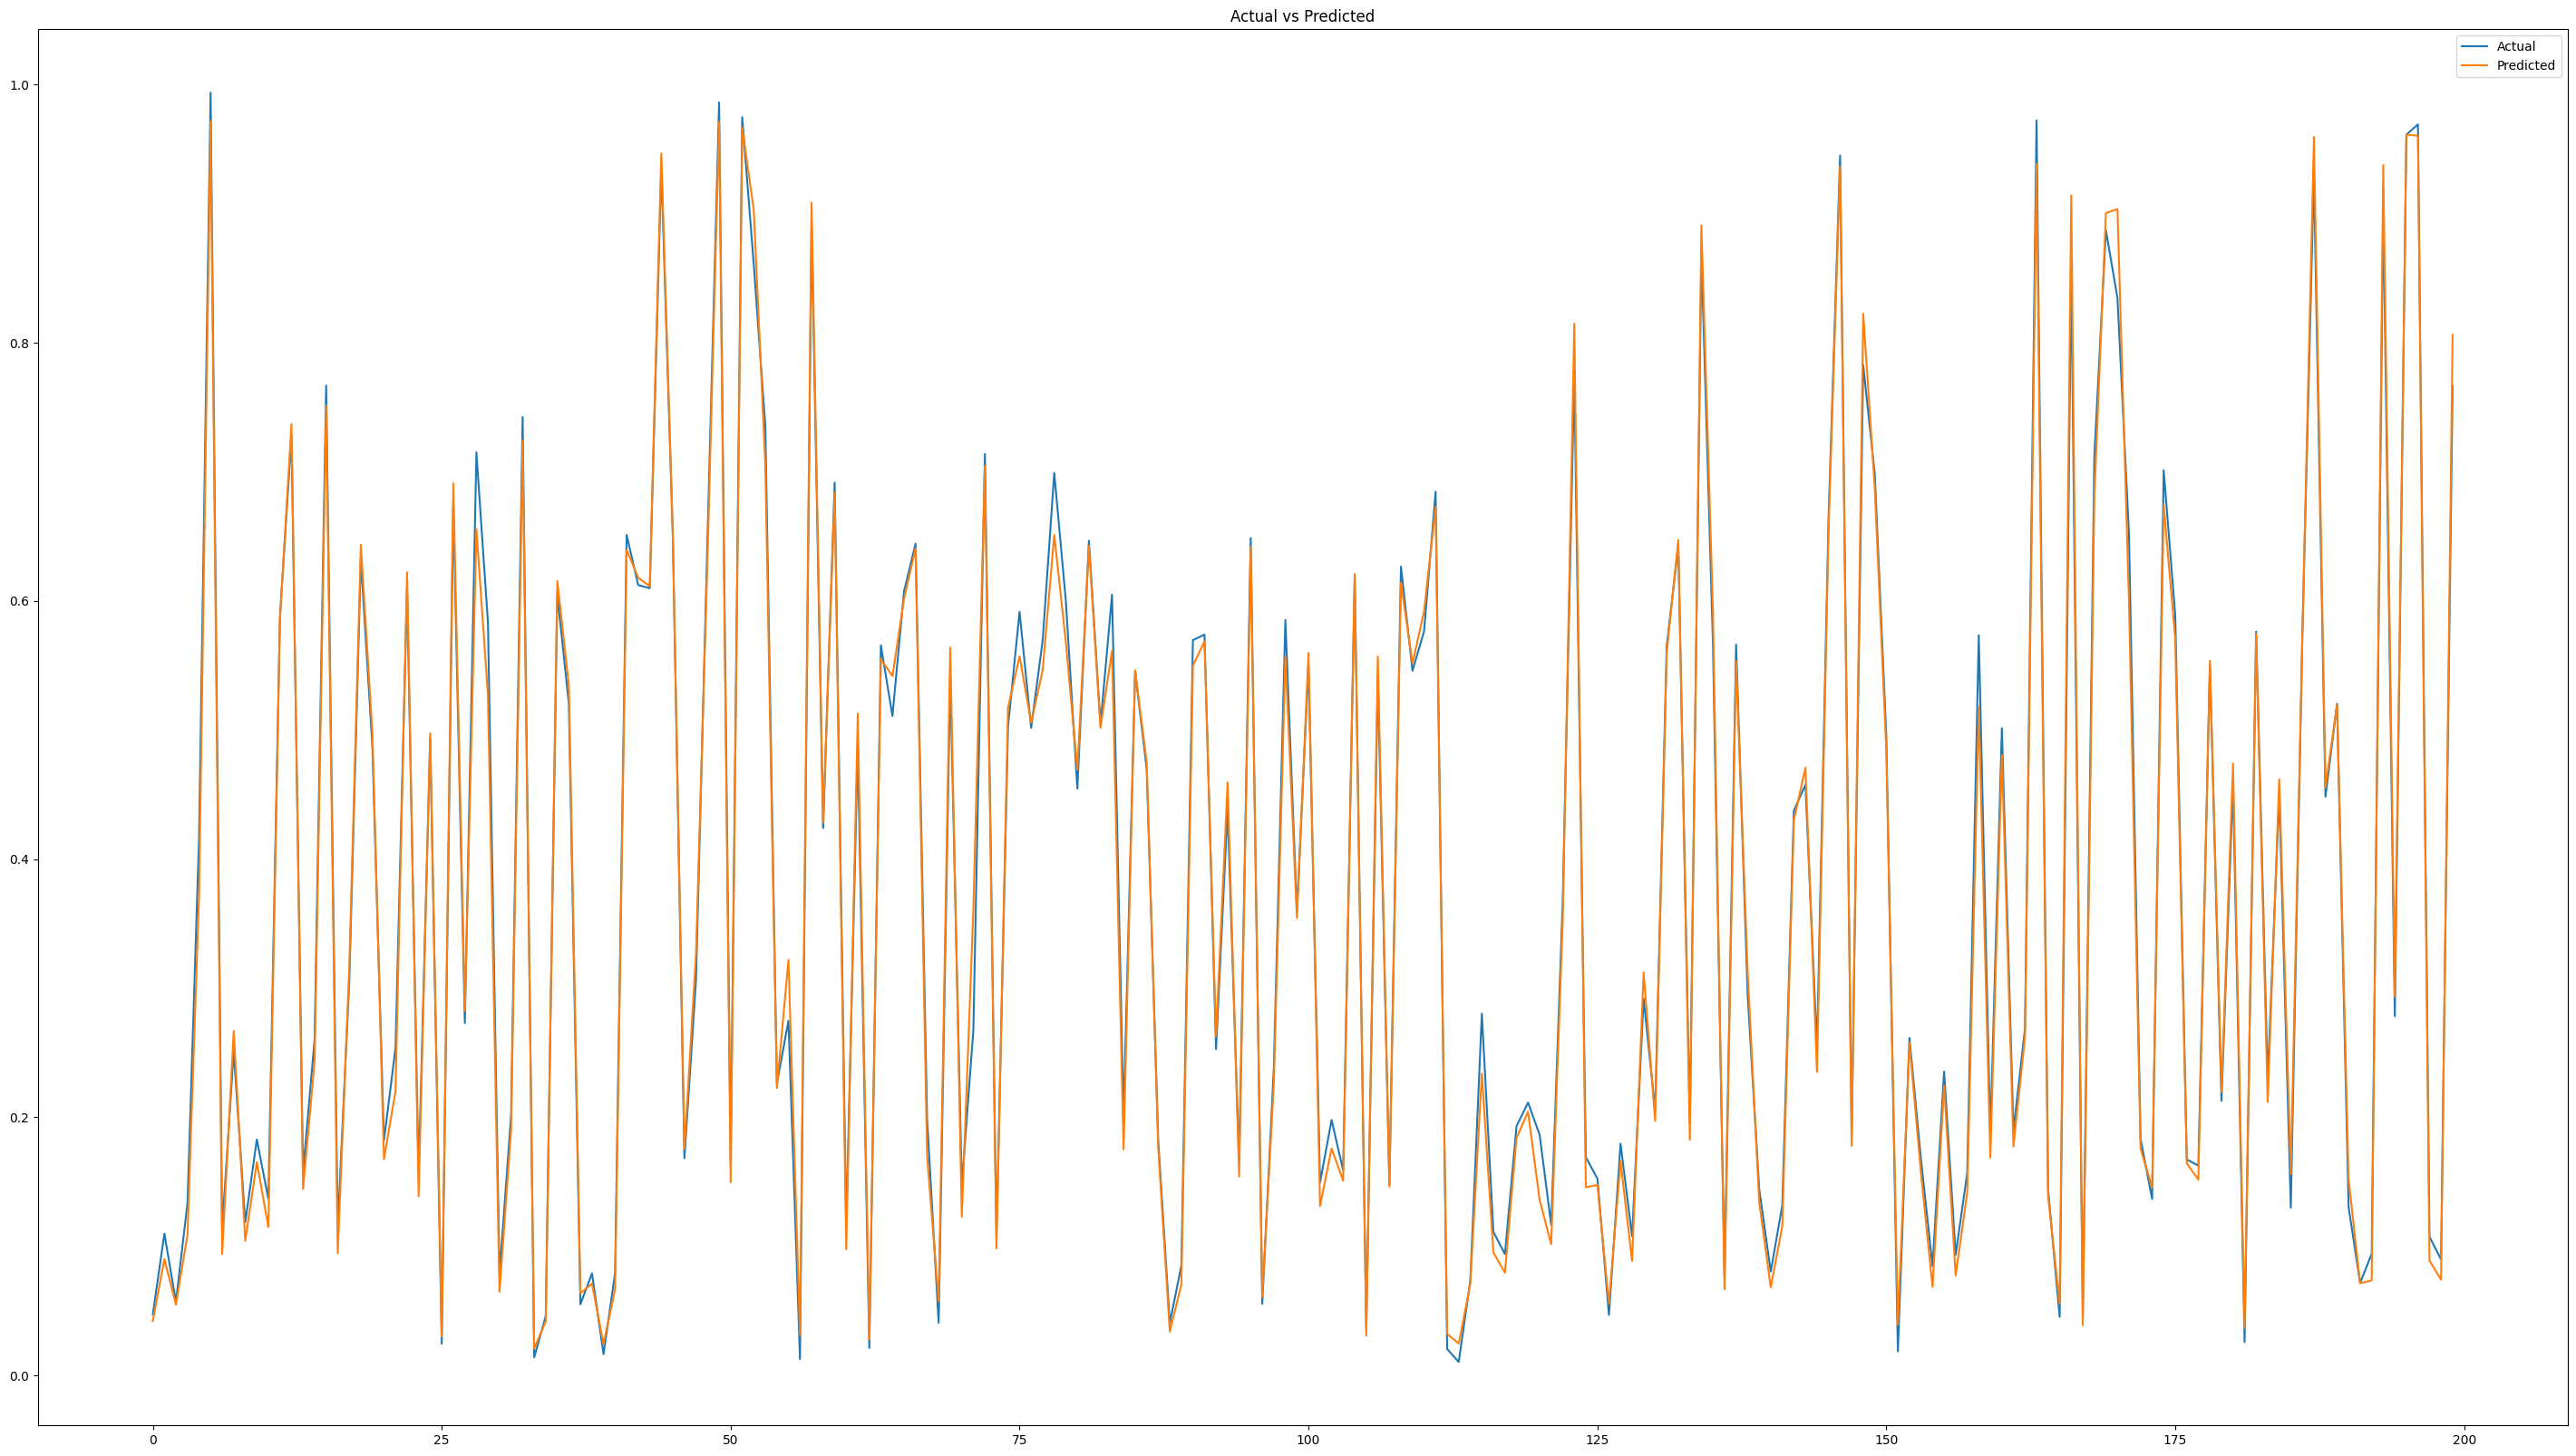

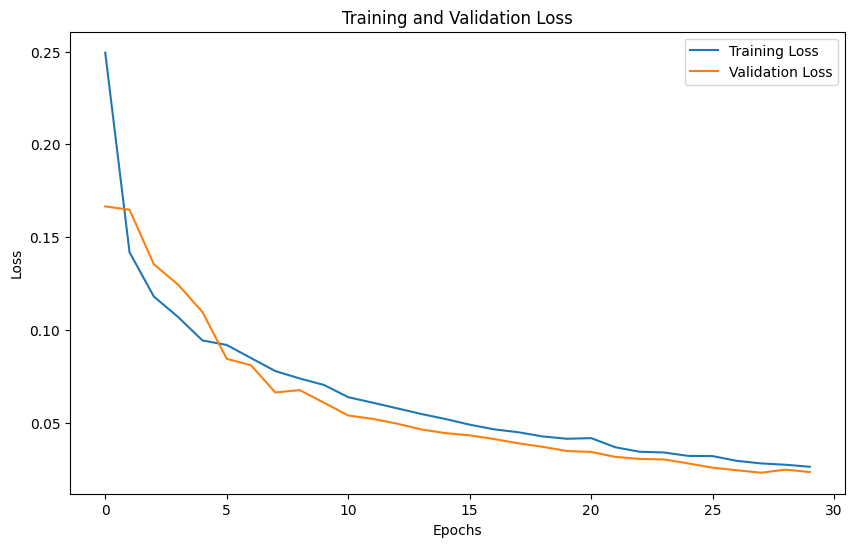

In [10]:
# 시각화
plt.figure(figsize=(36, 20))
plt.plot(y_test[100:300].flatten(), label='Actual')
plt.plot(y_pred[100:300].flatten(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

### 4.2 LSTM

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - loss: 0.0953 - val_loss: 0.0643
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0611 - val_loss: 0.0474
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0444 - val_loss: 0.0338
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0322 - val_loss: 0.0242
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0235 - val_loss: 0.0178
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0173 - val_loss: 0.0135
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0129 - val_loss: 0.0101
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0098 - val_loss: 0.0073
Epoch 9/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0077 - val_loss: 0.0059
Epoch 10/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0061 - val_loss: 0.0046
Epoch 11/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 12/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0

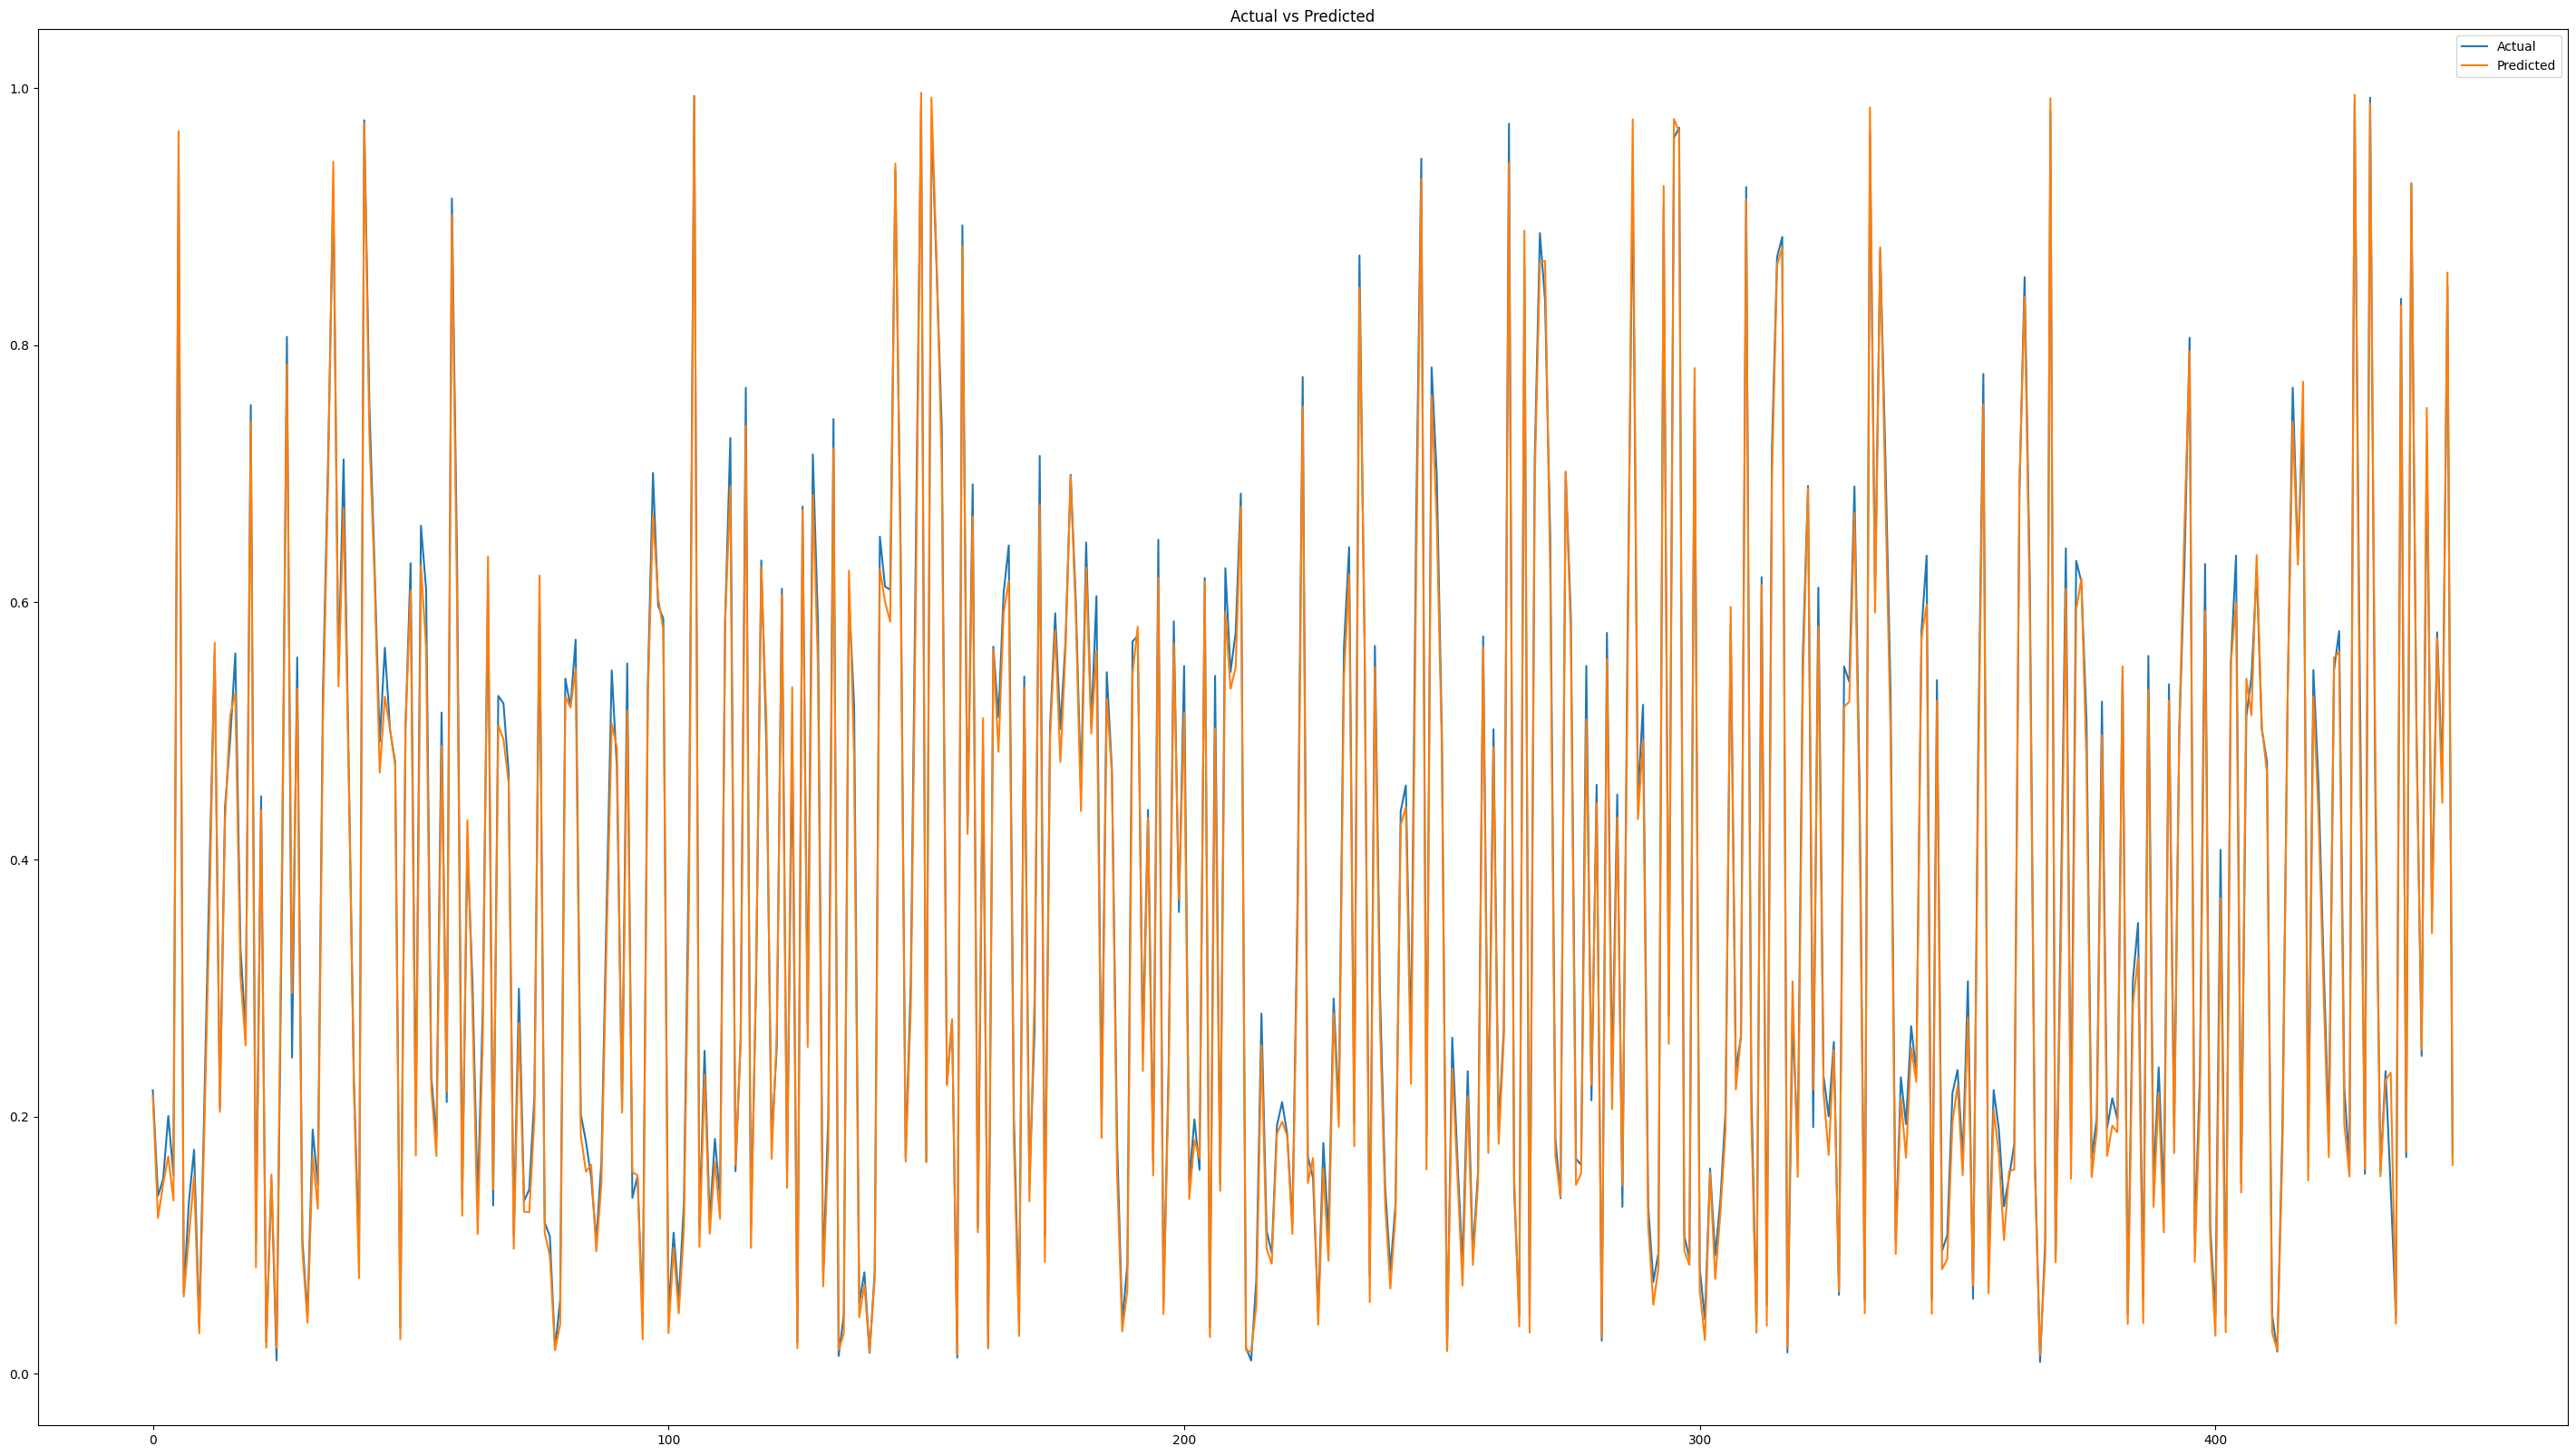

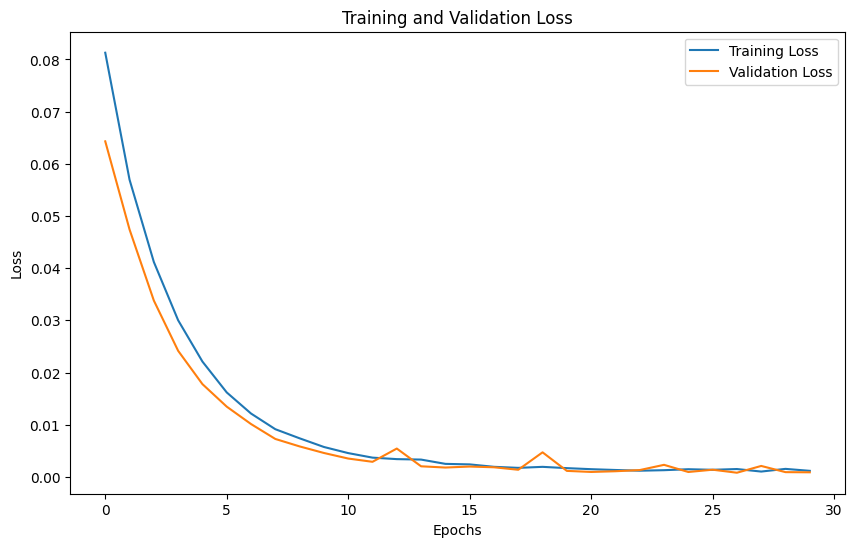

In [11]:
# 시퀀스별로 Min-Max 정규화
scaler = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)
y_scaled = scaler.fit_transform(y)
from tensorflow.keras import regularizers


# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 초기화 함수 정의
initializer = GlorotNormal()

# 모델 구성
model2 = Sequential()
model2.add(LSTM(128, input_shape=(SEQ_SIZE, X_train.shape[2]), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(64, return_sequences=False))
model2.add(Dropout(0.2))
model2.add(Dense(32, activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.002)))
model2.add(Dense(1))
optimizer = Adam(learning_rate=0.001)

model2.compile(optimizer=optimizer, loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model2.fit(X_train, y_train, epochs=EPOCH, validation_split=0.2, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# 모델 평가
loss = model2.evaluate(X_test, y_test)
print(f'테스트 손실: {loss}')

# 예측
y_pred = model2.predict(X_test)

# 성능 평가 지표
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'MSE: {mse}')
print(f'MAE: {mae}')

# 시각화
plt.figure(figsize=(36, 20))
plt.plot(y_test.flatten(), label='Actual')
plt.plot(y_pred.flatten(), label='Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()